In [209]:
from paths import DATASET_IMG, FRONTAL, LATERAL
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import imutils
import math
from sklearn.linear_model import LogisticRegression

In [117]:
FRONTALIMAGES = [str(FRONTAL / image_name) for image_name 
                        in os.listdir(FRONTAL)]

LATERALIMAGES = [str(LATERAL / image_name) for image_name 
                        in os.listdir(LATERAL)]

In [113]:
def distance_bounding_boxes(box1, box2):
    # Define the coordinates of the two bounding boxes as (x_min, y_min, x_max, y_max)
    (x_min1, y_min1, x_max1, y_max1) = box1
    (x_min2, y_min2, x_max2, y_max2) = box2

    # Calculate the center coordinates of the two bounding boxes
    center1 = ((x_min1 + x_max1) / 2, (y_min1 + y_max1) / 2)
    center2 = ((x_min2 + x_max2) / 2, (y_min2 + y_max2) / 2)

    # Define a distance threshold (you can adjust this as needed)
    distance_threshold = 10  # Adjust this threshold as needed

    # Calculate the Euclidean distance between the centers of the two bounding boxes
    distance = math.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

    # Check if the distance is less than the threshold to determine if they are near
    if distance < distance_threshold:
       return True
    else:
        return False
    
def find_license_plate_aspect_ratio(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)

    good_contours = []
    height, width = edged.shape
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.2
    border_buffer_y = height * 0.2
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
                aspect_ratio = float(w) / h
                if (1.2 < aspect_ratio < 8):
                    good_contours.append(contour)
                    
    good_contours = sorted(good_contours, key=cv2.contourArea, reverse=True)[:200]
    return None if len(good_contours) == 0 else good_contours

def preprocess_image(img_path):
    """Preprocess the image and return required intermediates."""
    # Read the image
    img = cv2.imread(img_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Noise reduction using bilateral filter
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge detection using Canny
    edged = cv2.Canny(bfilter, 30, 200)
    return img, gray, edged

def read_files():
    xml_files, png_files = [], []
    for file in os.listdir(DATASET_IMG):
        xml_files.append(str(DATASET_IMG / file)) if file.endswith('.xml') else png_files.append(str(DATASET_IMG / file))
    return xml_files, png_files

# Image for the cordiantes
def bounding_box_licensplate(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    return ymin, xmin, ymax, xmax

def obtain_negative_samples(xml_file, img, gray, locations):
    box1 = bounding_box_licensplate(xml_file)
    cropped_image_noise = []
    for location in (locations):
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask==255)
        (xmin, ymin) = (np.min(x), np.min(y))
        (xmax, ymax) = (np.max(x), np.max(y))
        box2 = (xmin, ymin, xmax, ymax)
        cropped_image = gray[xmin:xmax+1, ymin:ymax+1]
        if not distance_bounding_boxes(box1, box2):
            cropped_image_noise.append(cropped_image)
    return cropped_image_noise

# Main method to process the image and visualize the results
def negative_samples(xml_path, img_path):
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_image_noise = obtain_negative_samples(xml_path, img, gray, locations)
    return cropped_image_noise
    #return img, locations # Returns the contours that SVM needs to classify

In [114]:
def licensplate(xml_path, image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    # Load XML from file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Extract bounding box
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    licenseplate = img[ymin:ymax, xmin:xmax]
    shape = licenseplate.shape
    if not 0 in shape:
        return licenseplate
    return None


In [174]:
xml_files, png_files = read_files()

negative_samples_list = []
licensplates = []

for xml_path, img_path in zip(xml_files, png_files):
    licen = licensplate(xml_path, img_path)
    if licen is None:
        continue
    licens_gray = cv2.cvtColor(licen, cv2.COLOR_RGB2GRAY)
    licensplates.append(licens_gray)
idx = 0
for xml_path, img_path in zip(xml_files, png_files):
    if idx == 6:
        break
    idx += 1
    negative_samples_list.extend(negative_samples(xml_path, img_path))

In [175]:
def obtain_sift_features(gray_licensplates): # All the images are not gray
    sift = cv2.SIFT_create()
    sift_features = []

    sift_features =  list(map(lambda gray_image: sift.detectAndCompute(gray_image, None)[1], gray_licensplates))
    
    sift_features = filter(lambda image_path: image_path is not None, sift_features)
    sift_features = list(map(lambda features: features.sum(0), sift_features))

    sift_features = np.vstack(sift_features)


    return sift_features

In [217]:
features_licensplate, features_noise = obtain_sift_features(licensplates), obtain_sift_features(negative_samples_list)
X = np.vstack((features_licensplate, features_noise))
Y = np.vstack((np.ones((len(features_licensplate), 1)), np.zeros((len(features_noise), 1))))

In [215]:
from sklearn import preprocessing

In [218]:
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.33, random_state=42)

In [220]:
clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train.ravel())

In [222]:
clf = svm.SVC(kernel='rbf', C=1.0)
clf.fit(X_train, y_train.ravel())

SVC()

In [223]:
(y_test.ravel() == clf.predict(X_test)).sum() / len(y_test.ravel())

0.7557251908396947

In [180]:
def find_license_plate_aspect_ratio(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)

    good_contours = []
    height, width = edged.shape
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.2
    border_buffer_y = height * 0.2
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
                aspect_ratio = float(w) / h
                if (1.2 < aspect_ratio < 8):
                    good_contours.append(contour)
    good_contours = sorted(good_contours, key=cv2.contourArea, reverse=True)[:200]
    return None if len(good_contours) == 0 else good_contours

def extract_patch_from_image(img, gray, locations):
    cropped_images = []

    for location in (locations):
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1:x2+1, y1:y2+1]
        cropped_images.append(cropped_image)
    return cropped_images

# Main method to process the image and visualize the results
def method_3(img_path):
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_images = extract_patch_from_image(img, gray, locations)
    return cropped_images
    #return img, locations # Returns the contours that SVM needs to classify

In [201]:
cropped_images = method_3(FRONTALIMAGES[8])
features = obtain_sift_features(cropped_images)

In [202]:
result = clf.predict(features)
np.where(1 == result)

(array([  3,  22,  26,  32,  43,  54,  64, 131], dtype=int64),)

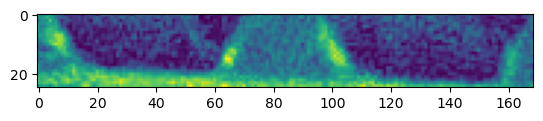

In [207]:
plt.imshow(cropped_images[43])

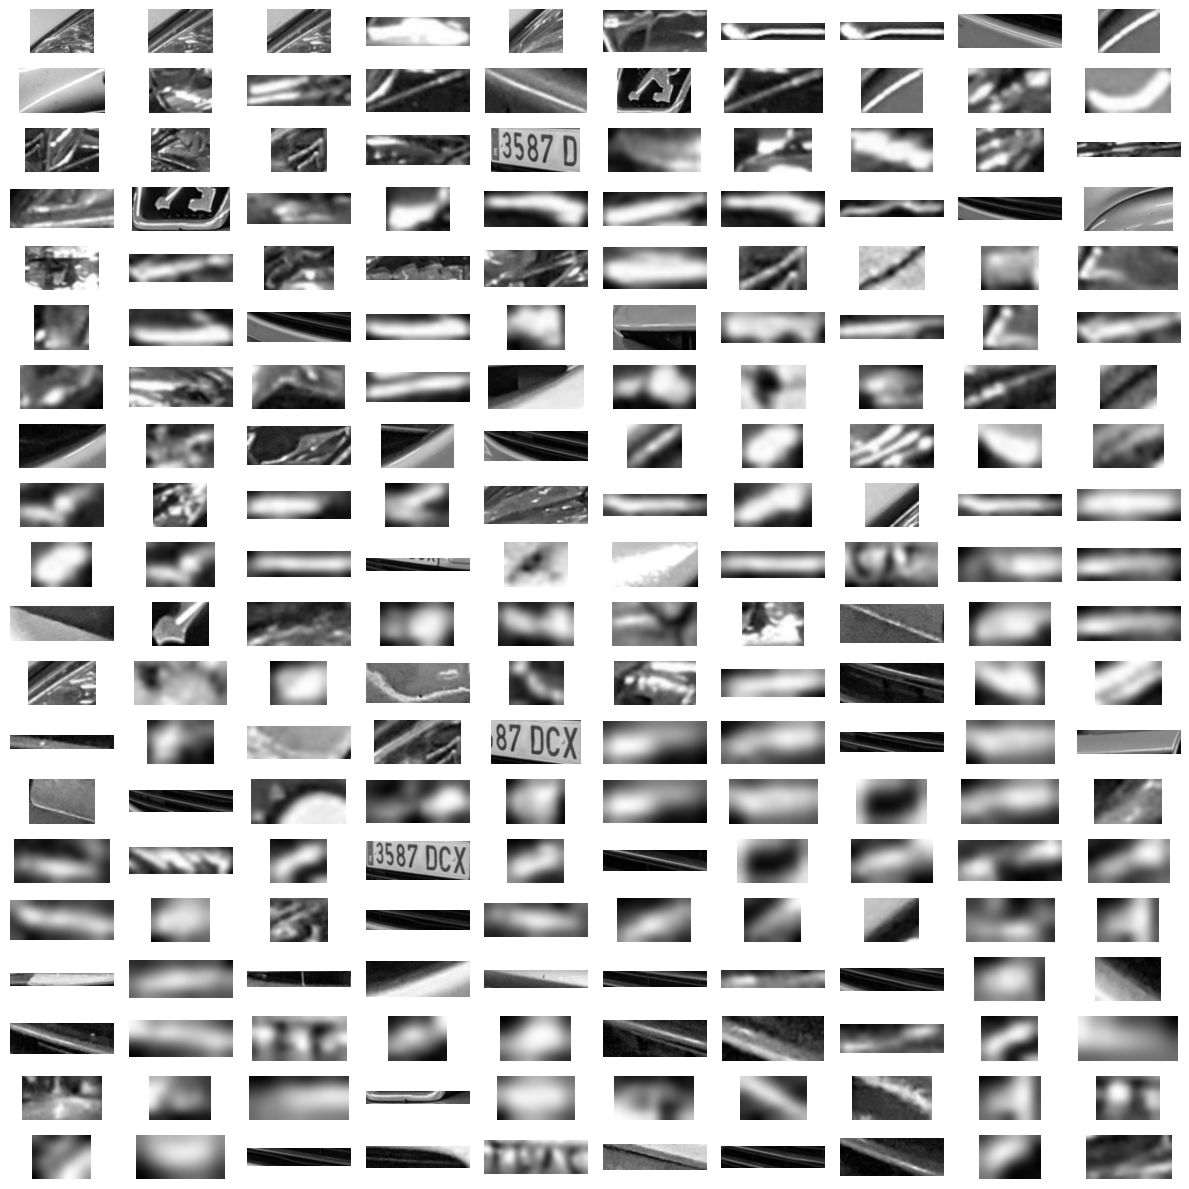

In [126]:
import matplotlib.pyplot as plt
# Assuming cropped_images is a list of images

# Set the figure size to make subplots larger
fig = plt.figure(figsize=(12, 12))
idx = 1
# Create a 10x10 grid of subplots
for image in (cropped_images[:200]):
    plt.subplot(20, 10, idx)
    
    # Adjust the aspect ratio to prevent stretching
    plt.gca().set_aspect('equal', adjustable='box')
    
    # You can adjust the size of the image by setting the interpolation
    plt.imshow(image, cmap='gray', interpolation='bicubic')
    
    plt.axis('off')  # Optional: Hide axis labels
    idx += 1
plt.tight_layout()
plt.show()


In [6]:
import imutils

def preprocess_image(img_path):
    """Preprocess the image and return required intermediates."""
    # Read the image
    img = cv2.imread(img_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Noise reduction using bilateral filter
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge detection using Canny
    edged = cv2.Canny(bfilter, 30, 200)
    return img, gray, edged

def find_license_plate_aspect_ratio(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)

    good_contours = []
    height, width = edged.shape
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.2
    border_buffer_y = height * 0.2
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
                aspect_ratio = float(w) / h
                if (1.2 < aspect_ratio < 8):
                    good_contours.append(contour)
                    
    good_contours = sorted(good_contours, key=cv2.contourArea, reverse=True)[:200]
    return None if len(good_contours) == 0 else good_contours

def extract_patch_from_image(xml_file, img, gray, locations):
    box1 = bounding_box_licensplate(xml_file)

    cropped_image_noise = []
    cropped_images_licensplates = []
    for location in (locations):
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask==255)
        (xmin, ymin) = (np.min(x), np.min(y))
        (xmax, ymax) = (np.max(x), np.max(y))

        box2 = (xmin, ymin, xmax, ymax)
        cropped_image = gray[xmin:xmax+1, ymin:ymax+1]
        if not distance_bounding_boxes(box1, box2):
            cropped_image_noise.append(cropped_image)
            
    return cropped_images_licensplates, cropped_image_noise

# Main method to process the image and visualize the results
def method_3(xml_path, img_path):
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_images_licensplates, cropped_image_noise = extract_patch_from_image(xml_path, img, gray, locations)
    return cropped_images_licensplates, cropped_image_noise
    #return img, locations # Returns the contours that SVM needs to classify

In [7]:
cropped_images, noise = method_3(xml_files[15], png_files[15])

In [ ]:
cropped_images, noise = method_3(xml_files[15], png_files[15])
for i in range(1, len(noise)):
    plt.subplot((len(noise) // 4), 5, i)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.imshow(noise[i], cmap='gray', interpolation='bicubic')
    plt.axis('off')  # Optional: Hide axis labels

plt.tight_layout()
plt.show()

In [ ]:
def obtain_dataset():
    # Crop de la imatge i si es matricula o no
    xml_files, png_files = [], []
    for file in os.listdir(DATASET_IMG):
        xml_files.append(str(DATASET_IMG / file)) if file.endswith('.xml') else png_files.append(str(DATASET_IMG / file))
    
    cropped_images = method_3(png_files)
    

In [9]:
samples = []
for image_path, xml_path in zip(png_files, xml_files):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    # Load XML from file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Extract bounding box
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    licenseplate = img[ymin:ymax, xmin:xmax]

    shape = licenseplate.shape
    if not 0 in shape:
        samples.append(licenseplate)




In [ ]:
_, fig = plt.subplots(5, 5, figsize=(10, 10))
num = 0
for i in range(5):
    for j in range(5):
        fig[i, j].imshow(samples[num])
        num += 1


In [12]:
def obtain_sift_features(gray_licensplates): # All the images are not gray
    sift = cv2.SIFT_create()
    sift_features = []

    sift_features =  list(map(lambda gray_image: sift.detectAndCompute(gray_image, None)[1], gray_licensplates))
    
    sift_features = filter(lambda image_path: image_path is not None, sift_features)
    sift_features = list(map(lambda features: features.sum(0), sift_features))

    sift_features = np.vstack(sift_features)


    return sift_features

In [72]:
for i in range(80, 100):
    _, noisee = method_3(xml_files[i], png_files[i])
    noise.extend(noisee)

In [73]:
features_good, features_noise = obtain_sift_features(samples), obtain_sift_features(noise)

In [74]:
X_train = np.vstack((features_good, features_noise))

In [75]:
features_good, features_noise = obtain_sift_features(samples), obtain_sift_features(noise)
X_train = np.vstack((features_good, features_noise))
y_train = np.vstack((np.ones((len(features_good), 1)), np.zeros((len(features_noise), 1))))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [78]:
clf = svm.SVC(kernel='rbf', C=1.0)
clf.fit(X_train, y_train.ravel())

SVC()

In [42]:
y_test.ravel()

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.])

In [79]:
(y_test.ravel() == clf.predict(X_test)).sum() / len(y_test.ravel())

0.95097037793667

In [ ]:
# Image for the cordiantes
def bounding_box_licensplate(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    
    return ymin, ymax, xmin, xmax

In [11]:
pred = np.expand_dims(X_train[43], axis=0)

In [12]:
clf.predict(pred)

array([1.])

In [13]:
FRONTALIMAGES = [FRONTAL / image_name for image_name 
                        in os.listdir(FRONTAL)]

LATERALIMAGES = [LATERAL / image_name for image_name 
                        in os.listdir(FRONTAL)]

WindowsPath('D:/NIL/Uni/licensplates/Test/Frontal')